In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
%matplotlib inline
provider = IBMQ.load_account()

## Problem 11 [8 points]: Grover’ search Design and test the Grovers’ search with 2 Qbits.


* [4 points] Explain the basic elements of the quantum circuit including oracles and other operators. 
* [2 points] Design and test the algorithm with Qiskit.
* [2 points] Find out what happens if one applies Grover’ iterations more times than needed.

The solution mainly based on Qiskit textbook and Qiskit Global Summer School in July 2020 lecture notes

Grover's algorithm has three main components. 
1. Creating a superposition of all $2^n$ computational basis states by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 
2. Applying an Oracle operator to mark the appropriate elements among the $2^n$ elements. The oracle operator applies a coefficient of $-1$ to each of the marked elements.
3. Applying a Grover diffusion operator (Diffuser), which inverts the amplitude of all elements about the average amplitude.

Combining these components together, and applying the Oracle and Diffusion operators $O(\sqrt{N = 2^n})$ times. Grover's algorithm allows to determine the elements that were marked by the Oracle operator with high probability. 

Illustartion from qiskit textbook:

![image](grover.png)

Defining the Grover's algorithm for the case n = 2 (N=4) and the target state is |11> which encodes number 4


In [25]:
def phase_oracle():
    
    qc = QuantumCircuit(2, name='Oracle')
    qc.cz(0,1)

    return qc

In [26]:
def diffuser():
    
    qc = QuantumCircuit(2, name='Diffuser')
    qc.h([0,1])
    qc.z([0,1])
    qc.cz(0,1)
    qc.h([0,1])

    return qc

In [41]:
def Grover(n):
    
    qc = QuantumCircuit(2, 2)
    qc.h([0,1])
    for _ in range(n):
        qc.append(phase_oracle(), range(2))
        qc.append(diffuser(), range(2))
        
    qc.measure(range(2), range(2))
  
    return qc

Since in the particular case of  N=4 only one rotation is required we can combine the above components to build the full circuit for Grover's algorithm

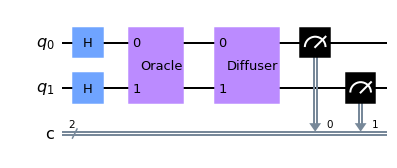

In [43]:
mycircuit = Grover(1)
mycircuit.draw('mpl')

In [37]:
my_provider = IBMQ.get_provider(hub='ibm-q')
my_provider.backends()

from qiskit.providers.ibmq import least_busy

small_devices = my_provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
least_busy(small_devices)

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [38]:
backend  = least_busy(small_devices)
jobIBM=execute(mycircuit,backend=backend,shots=1024)
job_monitor(jobIBM, interval = 2)
resultExp=jobIBM.result()

Job Status: job has successfully run


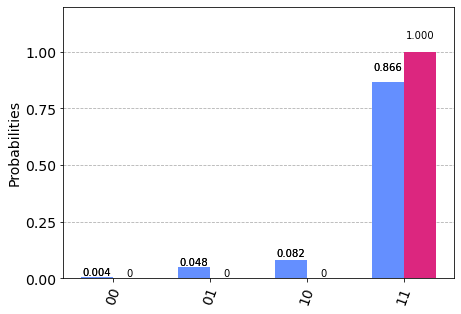

In [40]:
simulator = Aer.get_backend('qasm_simulator')
resultSim = execute(mycircuit, backend=simulator, shots=1000).result()
plot_histogram([resultExp.get_counts(mycircuit),resultSim.get_counts(mycircuit)])

Well, it seems that algorithm works both on simulation and real quantum machines. Now let's do the same with more Oracle + Diffuser operators then needed.

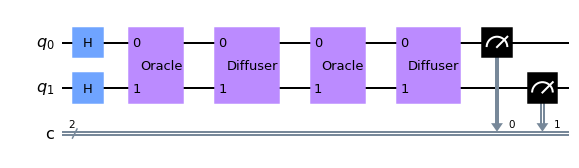

In [70]:
mycircuit_2 = Grover(2)
mycircuit_2.draw('mpl')

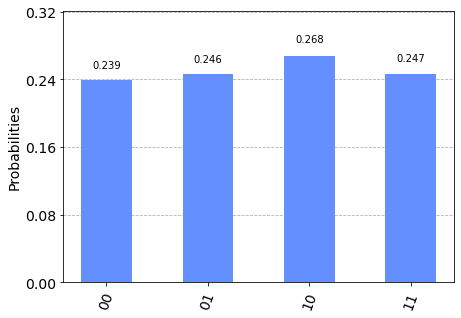

In [71]:

resultSim_2 = execute(mycircuit_2, backend=simulator, shots=1000).result()
plot_histogram(resultSim_2.get_counts(mycircuit_2))

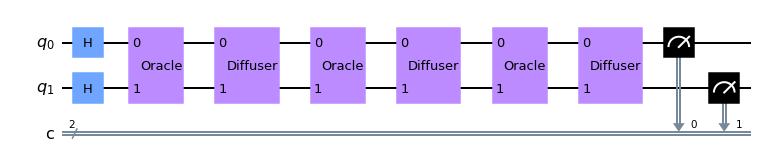

In [73]:
mycircuit_3 = Grover(3)
mycircuit_3.draw('mpl')

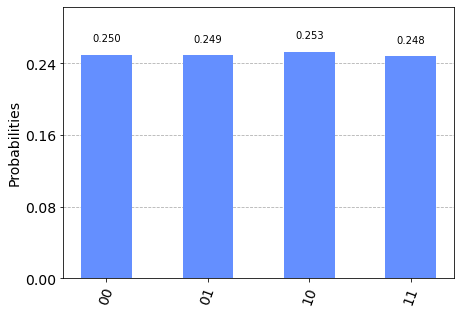

In [74]:
resultSim_3 = execute(mycircuit_3, backend=simulator, shots=1000).result()
plot_histogram(resultSim_3.get_counts(mycircuit_3))

As predicted by theory, if one apply more iteartions of Oracle + Diffuser than required (in case of 2 qubits that means more than 1) it is impossible to get any useful information. The meaning of Grover's algorithm is to increase the amplitude of the target state by decreasing the amplitude of all other states. Geometrically, Grover's algorithm consists in rotating the current state vector of a quantum system towards exactly the target state (moving along the shortest path ensures the optimality of Grover's algorithm). Further continuation of iterations of the iterations will continue to traverse the circle in the real plane generated by these vectors.